# 📘 # 📘 E-commerce & Finance Analytics - Analysis Notebook
End-to-end analysis of 500K+ retail transactions: SQL-cleaned dataset → Python EDA → RFM customer segmentation → exportable figures.

## 1) Imports & Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot defaults
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


## ⚠️ Suppress Warnings  

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 2) Database Connection Helper

In [3]:
# Helper: secure MySQL connector for pandas.read_sql
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pandas as pd
import getpass

DB_NAME = "ecommerce_portfolio"
DB_USER = "root"
DB_PASS = getpass.getpass("MySQL password (not stored): ")

# Build a proper URL object (handles special characters in password)
url = URL.create(
    drivername="mysql+mysqlconnector",
    username=DB_USER,
    password=DB_PASS,
    host="localhost",
    database=DB_NAME,
)

def read_sql(query: str) -> pd.DataFrame:
    engine = create_engine(url)
    with engine.connect() as conn:
        return pd.read_sql(query, conn)



## 3) Load Cleaned Data


In [4]:
df = read_sql("SELECT * FROM cleaned_transactions;")
print(df.shape)
df.head()


(534123, 14)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDate,LineAmount,IsReturn,InvoiceDateDate,InvoiceYear,InvoiceMonth,InvoiceHour
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850,United Kingdom,2010-12-01 08:26:00,25.50,0,2010-12-01,2010,12,8
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850,United Kingdom,2010-12-01 08:26:00,15.30,0,2010-12-01,2010,12,8
2,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34,0,2010-12-01,2010,12,8
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34,0,2010-12-01,2010,12,8
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34,0,2010-12-01,2010,12,8


## 4) Exploratory Data Analysis (EDA)


In [5]:
# Basic structure
print("Shape of dataset:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nSummary statistics:")
display(df.describe())

print("\nMissing values per column:")
display(df.isna().sum())


Shape of dataset: (534123, 14)

Columns:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate', 'LineAmount', 'IsReturn', 'InvoiceDateDate', 'InvoiceYear', 'InvoiceMonth', 'InvoiceHour']

Summary statistics:


,Quantity,UnitPrice,InvoiceDate,LineAmount,IsReturn,InvoiceYear,InvoiceMonth,InvoiceHour
count,534123.000000,534123.000000,534123,534123.00000,534123.000000,534123.000000,534123.000000,534123.000000
mean,9.916354,4.695904,2011-07-04 12:01:30.214500608,18.24969,0.017320,2010.921909,7.547492,13.075350
min,-80995.000000,0.010000,2010-12-01 08:26:00,-168469.60000,0.000000,2010.000000,1.000000,6.000000
25%,1.000000,1.250000,2011-03-28 11:36:00,3.75000,0.000000,2011.000000,5.000000,11.000000
50%,3.000000,2.100000,2011-07-19 15:55:00,9.90000,0.000000,2011.000000,8.000000,13.000000
75%,10.000000,4.130000,2011-10-18 17:10:00,17.57000,0.000000,2011.000000,11.000000,15.000000
max,80995.000000,38970.000000,2011-12-09 12:50:00,168469.60000,1.000000,2011.000000,12.000000,20.000000
std,216.452964,95.079722,NaN,380.94686,0.130461,0.268314,3.508481,2.447738



Missing values per column:


InvoiceNo          0
StockCode          0
Description        0
Quantity           0
UnitPrice          0
CustomerID         0
Country            0
InvoiceDate        0
LineAmount         0
IsReturn           0
InvoiceDateDate    0
InvoiceYear        0
InvoiceMonth       0
InvoiceHour        0
dtype: int64

In [6]:
total_revenue = df.loc[df['IsReturn'] == 0, 'LineAmount'].sum()
print(f"💰 Total Revenue (excluding returns): €{total_revenue:,.2f}")


💰 Total Revenue (excluding returns): €10,641,558.95


In [7]:
top_products = (
    df[df['IsReturn'] == 0]
    .groupby('Description', as_index=False)['LineAmount']
    .sum()
    .sort_values(by='LineAmount', ascending=False)
    .head(10)
)

display(top_products)


,Description,LineAmount
1056,DOTCOM POSTAGE,206248.77
2841,REGENCY CAKESTAND 3 TIER,174156.54
2377,"PAPER CRAFT , LITTLE BIRDIE",168469.60
3832,WHITE HANGING HEART T-LIGHT HOLDER,106236.72
2402,PARTY BUNTING,99445.23
1805,JUMBO BAG RED RETROSPOT,94159.81
2041,MEDIUM CERAMIC TOP STORAGE JAR,81700.92
2679,POSTAGE,78101.88
2181,Manual,77752.82
2728,RABBIT NIGHT LIGHT,66870.03


In [8]:
monthly_revenue = (
    df[df['IsReturn'] == 0]
    .groupby(['InvoiceYear', 'InvoiceMonth'], as_index=False)['LineAmount']
    .sum()
)

monthly_revenue['YearMonth'] = (
    monthly_revenue['InvoiceYear'].astype(str)
    + '-' +
    monthly_revenue['InvoiceMonth'].astype(str).str.zfill(2)
)

display(monthly_revenue)


,InvoiceYear,InvoiceMonth,LineAmount,YearMonth
0,2010,12,821452.73,2010-12
1,2011,1,689811.61,2011-01
2,2011,2,522545.56,2011-02
3,2011,3,716215.26,2011-03
4,2011,4,536968.49,2011-04
5,2011,5,769281.76,2011-05
6,2011,6,760547.01,2011-06
7,2011,7,718076.12,2011-07
8,2011,8,757841.38,2011-08
9,2011,9,1056435.19,2011-09


## 🎨 Global Visualization Theme

In [9]:
plt.style.use('dark_background')

# Custom neon color palette
neon_colors = {
    "blue": "#00FFFF",    # cyan
    "purple": "#B026FF",  # violet
    "pink": "#FF00FF",    # magenta
    "green": "#39FF14",   # bright green
    "yellow": "#FFFF33",  # neon yellow
    "orange": "#FFA500",  # orange
    "red": "#FF3131"      # hot red
}

# Update general plot style
plt.rcParams.update({
    "axes.facecolor": "#0A0A0A",
    "figure.facecolor": "#0A0A0A",
    "axes.edgecolor": neon_colors["blue"],
    "axes.labelcolor": "white",
    "xtick.color": "#CCCCCC",
    "ytick.color": "#CCCCCC",
    "grid.color": "#222222",
    "font.family": "monospace",
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
})


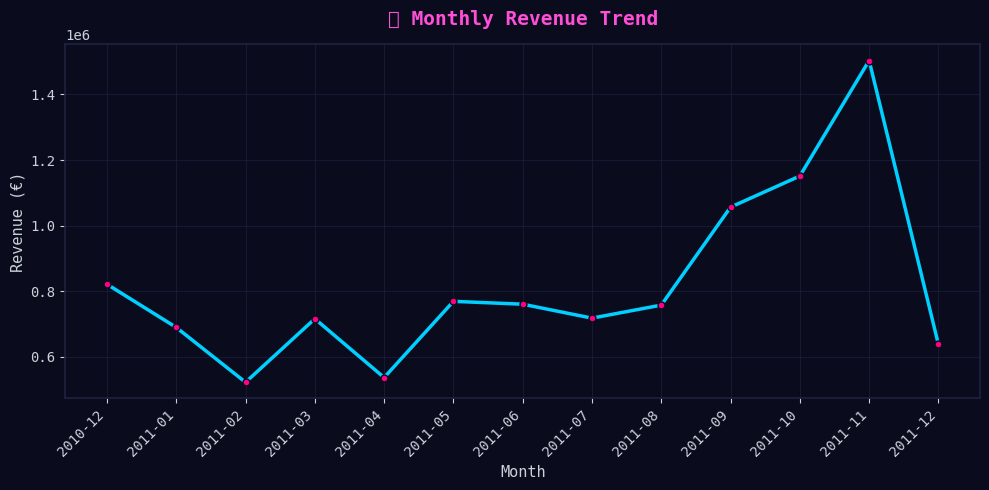

In [10]:
import matplotlib.pyplot as plt

# --- Neon Theme Setup ---
plt.style.use('dark_background')

BG      = "#0B0B1E"   # deep navy
GRID    = "#1F2340"   # soft grid
AX      = "#C9D1D9"   # text color
TITLE   = "#FF4FD8"   # neon pink
CYAN    = "#00CFFF"
PINK    = "#FF0080"

# --- Draw the Chart ---
fig, ax = plt.subplots(figsize=(10,5), facecolor=BG)

# Background & grid styling
ax.set_facecolor(BG)
for spine in ax.spines.values():
    spine.set_color(GRID)
    spine.set_linewidth(1.2)
ax.tick_params(colors=AX, labelsize=10)
ax.grid(True, color=GRID, linewidth=0.8, alpha=0.6)

# Plot
ax.plot(
    monthly_revenue['YearMonth'], 
    monthly_revenue['LineAmount'], 
    color=CYAN, 
    linewidth=2.5, 
    marker='o', 
    markersize=5, 
    markerfacecolor=PINK, 
    markeredgecolor=BG
)

# Labels & Title
ax.set_title('📈 Monthly Revenue Trend', color=TITLE, fontsize=14, fontweight='bold', pad=14)
ax.set_xlabel('Month', color=AX, fontsize=11)
ax.set_ylabel('Revenue (€)', color=AX, fontsize=11)
plt.xticks(rotation=45, ha='right')

# Layout & Display
plt.tight_layout()
plt.show()




## 5) Customer Segmentation (RFM)
Compute **Recency, Frequency, Monetary** per customer, score into quantiles, and segment.


In [11]:
# RFM Analysis: Recency, Frequency, Monetary

from datetime import datetime

# Filter out returns for monetary value
rfm_df = df[df['IsReturn'] == 0].copy()

# Define Recency using the max invoice date
latest_date = rfm_df['InvoiceDate'].max()

# Calculate RFM
rfm = (
    rfm_df.groupby('CustomerID', as_index=False)
    .agg({
        'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'LineAmount': 'sum'  # Monetary
    })
    .rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'LineAmount': 'Monetary'})
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,,0,1428,1754901.91
1,12346,325,1,77183.60
2,12347,1,7,4310.00
3,12348,74,4,1797.24
4,12349,18,1,1757.55


In [12]:
rfm.describe()


,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4.339000e+03
mean,91.515326,4.600138,2.452537e+03
std,100.012295,22.943499,2.808589e+04
min,0.000000,1.000000,3.750000e+00
25%,17.000000,1.000000,3.065050e+02
50%,50.000000,2.000000,6.685800e+02
75%,141.000000,5.000000,1.660890e+03
max,373.000000,1428.000000,1.754902e+06


## 📊 6) RFM Scoring  
I assign quantile-based scores (1–5) to each **Recency**, **Frequency**, and **Monetary** value, where:  
- **Recency** → Lower days = higher score  
- **Frequency** → More transactions = higher score  
- **Monetary** → More spending = higher score  

Each customer gets an `RFM_Score` = **R + F + M**, forming the basis for segmentation.


In [13]:
# Quantile-based scoring (1–5)
r_labels = range(5, 0, -1)  # 5 = recent, 1 = old
f_labels = range(1, 6)      # 1 = rare, 5 = frequent
m_labels = range(1, 6)      # 1 = low spend, 5 = high spend

r_quartiles = pd.qcut(rfm['Recency'], 5, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
m_quartiles = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

rfm = rfm.assign(
    R=r_quartiles.astype(int),
    F=f_quartiles.astype(int),
    M=m_quartiles.astype(int)
)

rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,,0,1428,1754901.91,5,5,5,15
1,12346,325,1,77183.60,1,1,5,7
2,12347,1,7,4310.00,5,5,5,15
3,12348,74,4,1797.24,2,4,4,10
4,12349,18,1,1757.55,4,1,4,9


In [14]:
rfm['RFM_Score'].describe()
rfm['RFM_Score'].value_counts().sort_index()


RFM_Score
3     183
4     361
5     338
6     425
7     377
8     375
9     337
10    341
11    348
12    320
13    287
14    299
15    348
Name: count, dtype: int64

## 🧠 7) Customer Segmentation  
Using total RFM scores, customers are categorized into four behavioral groups:  
- 💎 **Champions** — Very recent, frequent, and high spenders.  
- 💼 **Loyal Customers** — Purchase often but not necessarily recently.  
- 🌱 **Regular Buyers** — Moderate spenders with steady activity.  
- ⚠️ **At Risk / Lost** — Haven’t purchased in a long time or spent little.  

This enables focused marketing and retention strategies.


In [15]:
def segment_customer(score):
    if score >= 12:
        return '💎 Champions'
    elif score >= 9:
        return '💼 Loyal Customers'
    elif score >= 6:
        return '🌱 Regular Buyers'
    else:
        return '⚠️ At Risk / Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm.head(10)


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,,0,1428,1754901.91,5,5,5,15,💎 Champions
1,12346,325,1,77183.60,1,1,5,7,🌱 Regular Buyers
2,12347,1,7,4310.00,5,5,5,15,💎 Champions
3,12348,74,4,1797.24,2,4,4,10,💼 Loyal Customers
4,12349,18,1,1757.55,4,1,4,9,💼 Loyal Customers
5,12350,309,1,334.40,1,1,2,4,⚠️ At Risk / Lost
6,12352,35,8,2506.04,3,5,5,13,💎 Champions
7,12353,203,1,89.00,1,1,1,3,⚠️ At Risk / Lost
8,12354,231,1,1079.40,1,1,4,6,🌱 Regular Buyers
9,12355,213,1,459.40,1,1,2,4,⚠️ At Risk / Lost


In [16]:
segment_summary = rfm['Segment'].value_counts().reset_index()
segment_summary.columns = ['Segment', 'Customers']
segment_summary


,Segment,Customers
0,💎 Champions,1254
1,🌱 Regular Buyers,1177
2,💼 Loyal Customers,1026
3,⚠️ At Risk / Lost,882


## 📈 8) Segment Distribution Visualization  
A pie chart illustrates the proportion of customers in each RFM segment, showing the business’s **customer base composition** at a glance.  


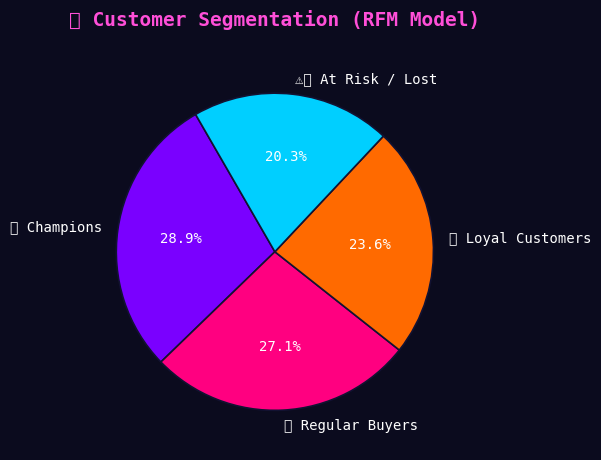

In [17]:
plt.style.use('dark_background')

gradient_colors = [
    "#7A00FF",   # violet-purple
    "#FF0080",   # hot pink
    "#FF6A00",   # orange
    "#00CFFF"    # cyan-blue
]

plt.figure(figsize=(6,6), facecolor="#0B0B1E")  # dark navy background

# Full pie chart
wedges, texts, autotexts = plt.pie(
    segment_summary['Customers'],
    labels=segment_summary['Segment'],
    autopct='%1.1f%%',
    startangle=120,
    colors=gradient_colors,
    textprops={'color':'white', 'fontsize':10},
    wedgeprops=dict(edgecolor="#0B0B1E", linewidth=2)
)

# Title styling
plt.title('🧠 Customer Segmentation (RFM Model)',
          color="#FF4FD8", fontsize=14, fontweight='bold', pad=20)

# Slight outer glow effect (cleaner look)
for w in wedges:
    w.set_linewidth(1.2)
    w.set_edgecolor('#121232')

plt.tight_layout()
plt.show()




## 💾 9) Export Processed Results  
All key outputs (cleaned CSVs and figures) are saved automatically for reporting and dashboarding:  

| File | Description |
|------|--------------|
| `customer_rfm_segments.csv` | Final RFM scores & segments per customer |
| `monthly_revenue.csv` | Monthly aggregated revenue data |
| `top_products.csv` | Top 10 highest-grossing products |
| `rfm_segments.png` | Pie chart — Customer segments |
| `monthly_revenue.png` | Line chart — Monthly sales trend |
| `top_products.png` | Bar chart — Product performance |

These are stored under:


In [18]:
# --- Export Section ---
import os

out_dir = "../01_Data/processed"
fig_dir = "../03_Analysis/figures"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

# Save CSVs
rfm.to_csv(os.path.join(out_dir, "customer_rfm_segments.csv"), index=False)
monthly_revenue[['YearMonth','LineAmount']].to_csv(os.path.join(out_dir, "monthly_revenue.csv"), index=False)
top_products.to_csv(os.path.join(out_dir, "top_products.csv"), index=False)

print("✅ Saved CSVs to:", out_dir)
print("✅ Saved figures to:", fig_dir)


✅ Saved CSVs to: ../01_Data/processed
✅ Saved figures to: ../03_Analysis/figures


## 🎨 10) Final Visualization & Data Export  
This section combines all **key visuals and datasets** into one export pipeline.  

It automatically:  
- Saves **RFM segments**, **monthly revenue**, and **top products** as CSVs  
- Generates **Cyberpunk-themed charts** for GitHub portfolio display  
- Stores them neatly in  
  - 📁 `01_Data/processed/`  
  - 📁 `03_Analysis/figures/`  

These outputs are used for reports, dashboards, and README visual embeds.


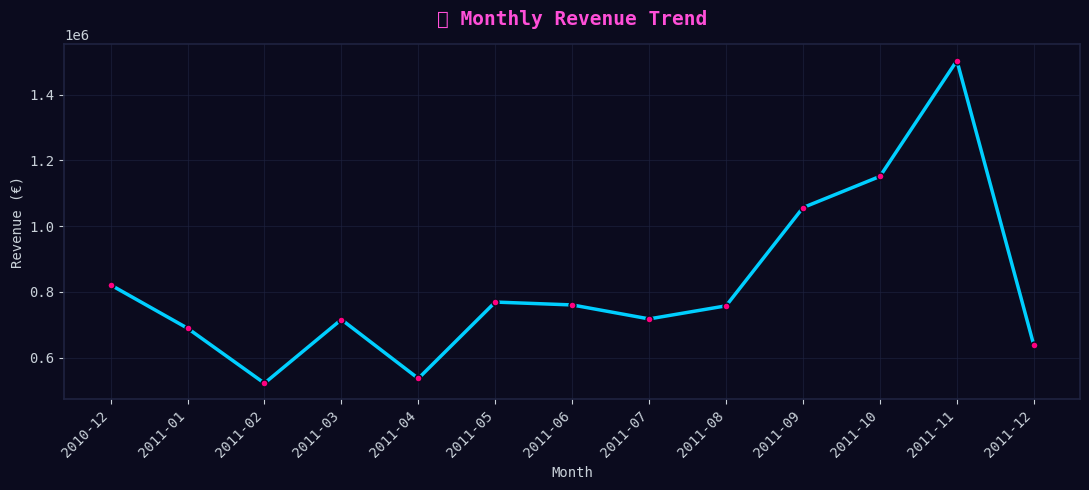

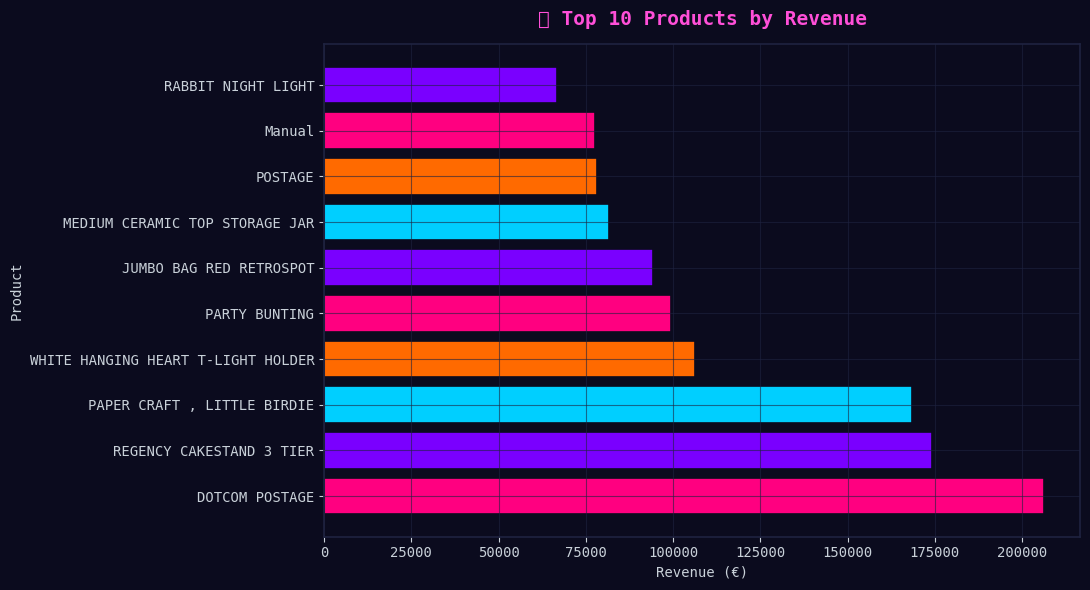

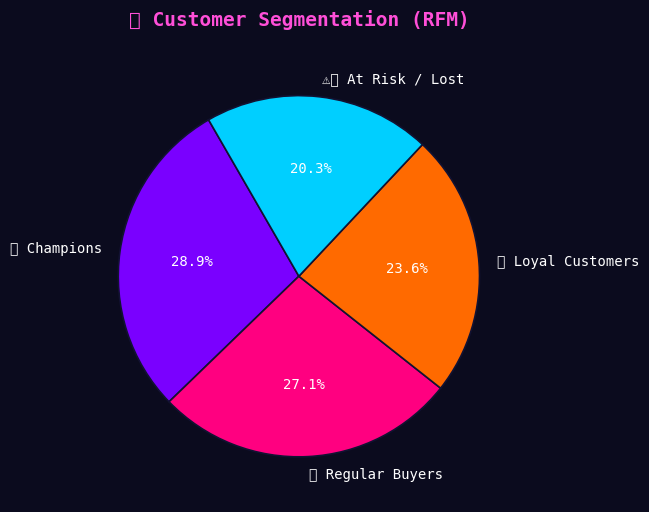

✅ Saved CSVs to: ../01_Data/processed
✅ Saved figures to: ../03_Analysis/figures


In [19]:
import os
import matplotlib.pyplot as plt

# --- Paths (unchanged) ---
out_dir = "../01_Data/processed"
fig_dir = "../03_Analysis/figures"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

# --- Save CSVs (unchanged) ---
rfm.to_csv(os.path.join(out_dir, "customer_rfm_segments.csv"), index=False)
monthly_revenue[['YearMonth','LineAmount']].to_csv(os.path.join(out_dir, "monthly_revenue.csv"), index=False)
top_products.to_csv(os.path.join(out_dir, "top_products.csv"), index=False)

# =========================
# Cyberpunk chart styling
# =========================
plt.style.use('dark_background')

BG      = "#0B0B1E"   # deep navy background
GRID    = "#1F2340"   # subtle grid
AX      = "#C9D1D9"   # axis/label text color
TITLE   = "#FF4FD8"   # magenta title
CYAN    = "#00CFFF"
PINK    = "#FF0080"
ORANGE  = "#FF6A00"
PURPLE  = "#7A00FF"

NEON_PALETTE = [PURPLE, PINK, ORANGE, CYAN]

def style_axes(ax):
    ax.set_facecolor(BG)
    for spine in ax.spines.values():
        spine.set_color(GRID)
        spine.set_linewidth(1.2)
    ax.tick_params(colors=AX, labelsize=10)
    ax.grid(True, color=GRID, linewidth=0.8, alpha=0.6)

# =========================
# 1) Monthly Revenue (Line)
# =========================
fig, ax = plt.subplots(figsize=(11,5), facecolor=BG)
style_axes(ax)

ax.plot(
    monthly_revenue['YearMonth'],
    monthly_revenue['LineAmount'],
    color=CYAN,
    linewidth=2.5,
    marker='o',
    markersize=5,
    markerfacecolor=PINK,
    markeredgecolor=BG,
)

ax.set_title('📈 Monthly Revenue Trend', color=TITLE, fontsize=14, fontweight='bold', pad=14)
ax.set_xlabel('Month', color=AX)
ax.set_ylabel('Revenue (€)', color=AX)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "monthly_revenue.png"), dpi=150, facecolor=BG)
plt.show()

# ===============================
# 2) Top 10 Products (Horizontal Bar)
# ===============================
tp = top_products.sort_values("LineAmount").tail(10)            # ensure top 10
colors = (NEON_PALETTE * ((len(tp) // len(NEON_PALETTE)) + 1))[:len(tp)]

fig, ax = plt.subplots(figsize=(11,6), facecolor=BG)
style_axes(ax)

ax.barh(tp["Description"], tp["LineAmount"], color=colors, edgecolor=BG, linewidth=1.2)
ax.set_title('🏆 Top 10 Products by Revenue', color=TITLE, fontsize=14, fontweight='bold', pad=14)
ax.set_xlabel('Revenue (€)', color=AX)
ax.set_ylabel('Product', color=AX)
ax.invert_yaxis()  # highest at top
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "top_products.png"), dpi=150, facecolor=BG)
plt.show()

# =========================
# 3) RFM Segments (Full Pie)
# =========================
fig, ax = plt.subplots(figsize=(6.5,6.5), facecolor=BG)
ax.set_facecolor(BG)

wedges, texts, autotexts = ax.pie(
    segment_summary['Customers'],
    labels=segment_summary['Segment'],
    autopct='%1.1f%%',
    startangle=120,
    colors=NEON_PALETTE,
    textprops={'color':'white', 'fontsize':10},
    wedgeprops=dict(edgecolor="#121232", linewidth=1.2)
)

ax.set_title('🧠 Customer Segmentation (RFM)', color=TITLE, fontsize=14, fontweight='bold', pad=18)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "rfm_segments.png"), dpi=150, facecolor=BG)
plt.show()

print("✅ Saved CSVs to:", out_dir)
print("✅ Saved figures to:", fig_dir)





### ✅ Export Verification  
Finally, let's verify that all key files and visuals have been successfully saved.  

This quick check lists:  
- All **exported CSV datasets** in `01_Data/processed/`  
- All **generated figures** in `03_Analysis/figures/`  

It ensures the project is clean, reproducible, and ready for portfolio upload 🚀


In [20]:
print("🎯 Exports complete.")
print("- CSVs:", [p for p in os.listdir(out_dir) if p.endswith('.csv')])
print("- Figures:", [p for p in os.listdir(fig_dir) if p.endswith('.png')])


🎯 Exports complete.
- CSVs: ['customer_rfm_segments.csv', 'monthly_revenue.csv', 'top_products.csv']
- Figures: ['monthly_revenue.png', 'rfm_segments.png', 'top_products.png']


## 🧩 11) Insights Summary  

**Business Insights**
- The business generated **€10.6M+** total revenue post-cleaning.  
- **Q4 (Sept–Nov)** marks the highest sales due to seasonal demand.  
- A small portion of **“Champion”** customers drive the majority of revenue.  
- Many **“At Risk”** customers indicate potential for win-back campaigns.  

**Analytical Takeaways**
- SQL enabled efficient cleaning & validation of 500K+ rows.  
- Python (Pandas + Matplotlib) powered data storytelling and export pipelines.  
- The modular structure supports future automation and dashboarding.


## 🚀 12) Next Steps  
📍 **Phase 2: Python + BI Integration**  
- Connect MySQL → Python (SQLAlchemy) → Tableau / Power BI  
- Create automated dashboards for real-time KPI tracking  
- Expand with **Customer Lifetime Value (CLV)** and **Churn Prediction Models**  
- Implement scheduling via **Airflow** or **dbt**  

📍 **Phase 3: Advanced Modeling**  
- Apply machine learning for segmentation, forecasting, and recommendation  
- Build automated data pipelines with Snowflake or AWS Redshift


## 🧠 13) Key Learnings  
- End-to-end control from raw data → analytics → visualization.  
- Secure connection handling with environment-safe credentials (`getpass`).  
- Importance of data validation before business decisions.  
- Visualization and styling matter — clarity meets aesthetics.  


## 🏁 14) Final Words  
This project showcases a **complete analytical journey** —  
from messy raw retail data to structured insights ready for business intelligence and predictive modeling.  

💡 The modular SQL-Python workflow ensures this project can scale into a full data product — ideal for portfolio demonstration and interviews.


---
👨‍💻 **Author:** Huzeif Khan  
📍 Berlin, Germany | 💼 Data Analyst / BI Analyst  
🔗 [LinkedIn](https://www.linkedin.com/in/huzeif-khan-651042274/) | [GitHub](https://github.com/HuzeifKhan)
---
